In [ ]:
  from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<br>
<br>
<br>
<br>

# **Preparação dos Dados (DataPrep) - Final**

A etapa de preparação dos dados (dataprep) é crucial para o sucesso da modelagem de machine learning, pois os dados precisam estar limpos, organizados e em um formato adequado para serem utilizados pelos algoritmos de aprendizado de máquina. Isso inclui garantir a qualidade dos dados, ajustar o formato para atender aos requisitos dos algoritmos, garantir eficiência computacional, promover interpretabilidade e explicabilidade dos modelos e assegurar generalização e robustez.
<br>
<br>
Como agora se trata de um caso mais complexo, onde vamos treinar o modelo para ter melhores métricas e não se trata mais de um modelo baseline, vamos fazer o processo manualmente, passo por passo, sem o uso de pipeline, para ter um controle maior de cada etapa, caso seja necessário fazer algum ajuste específico, utilizar diferentes técnicas de pré-processamento e para permitir ter mais flexibilidade também.
<br>
<br>
Nesta etapa também iremos fazer a seleção das variáveis utilizando algumas das técnicas mais usadas, para que o nosso modelo seja treinado somente com as variáveis mais relevantes.
<br>
<br>
**Nota 1: Nesta etapa final iremos juntar todas as variáveis selecionadas nas etapas anteriores e fazer o tratamento dessas variáveis (padronização e codificação), pois para alguns algoritmos será necessário. Após o tratamento vamos fazer uma nova seleção de variáveis, através do Feature Importance e também fazer cortes com base na Correlação de Pearson e do IV.**

<br>

## **Pacotes e Bibliotecas**

In [ ]:
# Instalação dos Pacotes.
!pip install colorama > /dev/null
!pip install category_encoders > /dev/null

In [ ]:
# Importando as bibliotecas Pandas e Numpy.
import pandas as pd
import numpy as np

# Importando as constantes definidas na biblioteca colorama que permitem alterar as cores e estilos de texto impresso no terminal.
from colorama import Fore, Style

# Importando a pickle para serialização.
import pickle

# Importando as bibliotecas necessárias para o tratamento dos dados.
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

# Importando os algoritmos de Machine Learning, da biblioteca Scikit-Learn, que iremos utilizar nesse projeto.
from sklearn.ensemble import GradientBoostingClassifier

# Importando a biblioteca Matplotlib e Seaborn para plotarmos gráficos que ajudarão no entendimento dos dados.
import matplotlib.pyplot as plt
import seaborn as sns

<br>
<br>
<br>
<br>

## **Funções**

In [ ]:
# Função para checar quantidade de linhas e colunas dos conjuntos de treino e teste.
def info_dataframe(treino, teste):
    '''
    Esta função exibe informações sobre a quantidade de linhas e colunas dos conjuntos de treino e teste.

    Parâmetros:
    - treino: DataFrame do conjunto de treino.
    - teste: DataFrame do conjunto de teste.

    Retorna:
    Um print com as informações.
    '''

    # Criando uma borda destacada para o título do conjunto de treino.
    print(Fore.BLUE + '=' * 45)
    print('CONJUNTO DE TREINO'.center(45))
    print('')
    print('Quantidade de linhas:', treino.shape[0])
    print('Quantidade de colunas:', treino.shape[1])
    print('=' * 45 + Style.RESET_ALL)
    print('')

    # Criando uma borda destacada para o título do conjunto de teste.
    print(Fore.GREEN + '=' * 45)
    print('CONJUNTO DE TESTE'.center(45))
    print('')
    print('Quantidade de linhas:', teste.shape[0])
    print('Quantidade de colunas:', teste.shape[1])
    print('=' * 45 + Style.RESET_ALL)



# =================================================================================================================================================== #



# Função para verificar os metadados do conjunto de dados.
def generate_metadata(df, ids, targets, orderby = 'PC_NULOS'):
    '''
    Esta função retorna uma tabela com informações descritivas sobre um DataFrame.

    Parâmetros:
    - df: DataFrame que você quer descrever.
    - ids: Lista de colunas que são identificadores.
    - targets: Lista de colunas que são variáveis alvo.
    - orderby: Ordenar por uma coluna específica.

    Retorna:
    Um DataFrame com informações sobre o df original.
    '''

    summary = pd.DataFrame({
        'USO_FEATURE': ['ID' if col in ids else 'Target' if col in targets else 'Explicativa' for col in df.columns],
        'QT_NULOS': df.isnull().sum(),
        'PC_NULOS': round((df.isnull().sum() / len(df))* 100,2),
        'CARDINALIDADE': df.nunique(),
        'TIPO_FEATURE': df.dtypes
    })

    summary_sorted = summary.sort_values(by=orderby, ascending=False)
    summary_sorted = summary_sorted.reset_index()

    # Renomeando a coluna 'index' para 'FEATURES'.
    summary_sorted = summary_sorted.rename(columns={'index': 'FEATURE'})

    return summary_sorted



# =================================================================================================================================================== #



# Função para preenchimento dos valores nulos.
def custom_fillna(df):
    '''
    Esta função preenche os valores nulos do DataFrame com a média das colunas numéricas e com 'VERIFICAR' para as colunas categóricas.

    Parâmetros:
    - df: DataFrame a ser preenchido.

    Retorna:
    O DataFrame preenchido e um dicionário contendo as médias das colunas numéricas.
    '''

    numerical_cols = df.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns
    means = {}

    for col in numerical_cols:
        means[col] = df[col].mean()
        df[col].fillna(means[col], inplace=True)

    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna('VERIFICAR')

    return df, means


# Função para preenchimento dos valores nulos em produção.
def custom_fillna_prod(df, means):
    '''
    Esta função preenche os valores nulos do DataFrame em produção.

    Parâmetros:
    - df: DataFrame a ser preenchido.
    - means: Dicionário contendo as médias das colunas numéricas.

    Retorna:
    O DataFrame preenchido.
    '''

    for col, mean_value in means.items():
      df[col].fillna(mean_value, inplace=True)

    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna('VERIFICAR')

    return df



# =================================================================================================================================================== #



# Função para checar as variáveis dummy.
def verificar_dummy(dataset, lista_dummy):
    '''
    Esta função verifica as variáveis dummy em um DataFrame.

    Parâmetros:
    - dataset: DataFrame a ser verificado.
    - lista_dummy: Lista para armazenar as variáveis dummy encontradas.

    Retorna:
    Um print com o Dataframe criado e a lista de variáveis dummy.
    '''

    # Inicializando um dicionário para armazenar as informações.
    dados = {'Feature': [], 'Registros_Unicos': [], 'Tipo': []}

    # Iterando sobre as colunas do DataFrame.
    for coluna in dataset.columns:
        # Verificando se a cardinalidade da coluna é igual a 2.
        if dataset[coluna].nunique() == 2:
            # Adicionando os dados ao dicionário.
            dados['Feature'].append(coluna)
            dados['Registros_Unicos'].append(list(dataset[coluna].unique()))
            dados['Tipo'].append(dataset[coluna].dtype)

            # Verificando se os registros únicos são apenas 0 e 1.
            if all(registro in ['0', '1', 0, 1] for registro in dataset[coluna].unique()):
                # Se o tipo for 'int64', adiciona à lista diretamente.
                if dataset[coluna].dtype == 'int64':
                    lista_dummy.append(coluna)
                # Se o tipo for 'object', converte para 'int64' e adiciona à lista.
                elif dataset[coluna].dtype == 'object':
                    dataset[coluna] = dataset[coluna].astype('int64')
                    lista_dummy.append(coluna)

    # Criando um DataFrame a partir do dicionário.
    resultado_verificar_dummy = pd.DataFrame(dados)

    # Imprimindo o DataFrame.
    print('')
    print(Fore.RED + Style.BRIGHT + 'DataFrame com as variáveis que possuem apenas 2 registros distintos' + Style.RESET_ALL)
    print('')
    print(resultado_verificar_dummy.to_string())
    print('')

    # Imprimindo a lista de variáveis dummy.
    print(Fore.BLUE + '=' * 150)
    print('\nLista de Variáveis Dummy:', lista_dummy)
    print('')
    print('=' * 150 + Style.RESET_ALL)



# =================================================================================================================================================== #



# Função para o cálculo do WoE e IV.
def calculate_woe_iv(df, feature, target):
    '''
    Calcula WoE (Weight of Evidence) e IV (Information Value) para uma variável.

    Parâmetros:
    - df: DataFrame do conjunto de treino.
    - feature: Nome da variável.
    - target: Nome da variável Target.

    Retorna:
    Os valores de WoE e IV das variáveis.
    '''

    lst = []
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': df[df[feature] == val].count()[feature],
            'Good': df[(df[feature] == val) & (df[target] == 1)].count()[feature],
            'Bad': df[(df[feature] == val) & (df[target] == 0)].count()[feature]
        })

    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()

    # Adicionando uma pequena constante para evitar divisão por zero.
    dset['Distr_Good'] = dset['Distr_Good'].replace({0: 1e-10})
    dset['Distr_Bad'] = dset['Distr_Bad'].replace({0: 1e-10})

    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()

    return iv



# Função para a criação de uma tabela com o IV das variáveis.
def iv_table(df, target):
    '''
    Cria uma tabela com o IV das variáveis.

    Parâmetros:
    - df: DataFrame do conjunto de treino.
    - target: Nome da variável Target.

    Retorna:
    Uma tabela com IV para todas as variáveis em relação ao target.
    '''

    iv_list = []
    for col in df.columns:
        if col == target:
            continue
        iv = calculate_woe_iv(df, col, target)
        if iv < 0.02:
            predictiveness = 'Inútil para a predição'
        elif iv < 0.1:
            predictiveness = 'Preditor Fraco'
        elif iv < 0.3:
            predictiveness = 'Preditor Moderado'
        else:
            predictiveness = 'Preditor Forte'
        iv_list.append({
            'Variável': col,
            'IV': iv,
            'Preditividade': predictiveness
        })

    return pd.DataFrame(iv_list).sort_values(by='IV', ascending=False)




<br>
<br>
<br>
<br>

## **Diretórios**

In [ ]:
# Salvando o caminho do diretório principal.
dir = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech'

# Salvando o caminho do diretório dos arquivos pickle.
dir_pkl = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech/modelo_desafiante/artefatos'

# Salvando o caminho do diretório das ABTs.
dir_abt = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech/modelo_desafiante/abt'

# Salvando o caminho do diretório das ABTs com as variáveis selecionadas nas etapas anteriores.
dir_abt_RL = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech/modelo_regressao_logistica/abt'

<br>
<br>
<br>
<br>

## **Leitura e merge dos dados**

**Bases de Treino**

In [ ]:
# Lendo as bases de dados.
base1 = pd.read_csv(dir_abt_RL + '/abt_train_fs_01.csv')
base2 = pd.read_csv(dir_abt_RL + '/abt_train_fs_02.csv')
base3 = pd.read_csv(dir_abt_RL + '/abt_train_fs_03.csv')
base4 = pd.read_csv(dir_abt_RL + '/abt_train_fs_04.csv')
base5 = pd.read_csv(dir_abt_RL + '/abt_train_fs_05.csv')
base6 = pd.read_csv(dir_abt_RL + '/abt_train_fs_06.csv')
base7 = pd.read_csv(dir_abt_RL + '/abt_train_cat.csv')

# Listando as colunas únicas de cada base de dados.
cols_base1 = set(base1.columns)
cols_base2 = set(base2.columns)
cols_base3 = set(base3.columns)
cols_base4 = set(base4.columns)
cols_base5 = set(base5.columns)
cols_base6 = set(base6.columns)
cols_base7 = set(base7.columns)

# Mesclar as bases.
abt_train_00 = base1.copy()  # Começa com a primeira base.

# Iterando sobre as bases restantes.
for base, cols in zip([base2, base3, base4, base5, base6, base7], [cols_base2, cols_base3, cols_base4, cols_base5, cols_base6, cols_base7]):
    # Remove as colunas que já existem na base atual.
    cols_to_add = [col for col in base.columns if col not in abt_train_00.columns]
    # Mescla a base atual com a base acumulada.
    abt_train_00 = abt_train_00.merge(base[cols_to_add + ['SK_ID_CURR']], on='SK_ID_CURR', how='outer')

# Mostrando tamanho da base após o merge.
print(Fore.BLUE + '=' * 150)
print('')
print('Tamanho do DataFrame: ', abt_train_00.shape)
print('')
print('=' * 150 + Style.RESET_ALL)


Tamanho do DataFrame:  (172205, 31)



In [ ]:
# Definindo a opção para não truncar colunas.
pd.set_option('display.max_columns', None)

abt_train_00.head(10)

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,TARGET,SK_ID_CURR,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U24M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,-19489,0.758916,0.526224,0.510090,1.000000,0.054453,0,281575,625500.0,34060.5,625500.0,4994.550000,4994.550000,4994.55000,4994.550000,Cash loans,F,Y,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Managers,THURSDAY,Trade: type 7,reg oper account,block of flats,"Stone, brick",No
1,-21070,0.502984,0.698457,0.367291,0.677879,0.051519,0,253241,278811.0,14364.0,189000.0,7911.140000,7911.140000,1076.58000,1076.580000,Cash loans,M,N,Y,"Spouse, partner",Working,Secondary / secondary special,Married,House / apartment,Laborers,SUNDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
2,-11513,0.287588,0.681713,0.150085,1.000000,0.106093,0,257591,193500.0,20529.0,193500.0,20029.939481,14352.211437,12372.27269,11432.662661,Cash loans,F,N,N,Unaccompanied,Working,Incomplete higher,Separated,House / apartment,Managers,WEDNESDAY,Business Entity Type 3,VERIFICAR,block of flats,Panel,No
3,-21850,0.502984,0.252310,0.510966,1.000000,0.056800,0,440634,135000.0,7668.0,135000.0,20029.939481,6.980000,6.98000,6.980000,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,VERIFICAR,MONDAY,XNA,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
4,-13273,0.502984,0.161661,0.490258,0.873210,0.029340,0,101232,1288350.0,37800.0,1125000.0,20029.939481,8649.270000,8649.27000,8649.270000,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Waiters/barmen staff,FRIDAY,Business Entity Type 3,VERIFICAR,block of flats,"Stone, brick",No
5,-19362,0.676316,0.652185,0.771362,0.782964,0.029338,0,378713,1333395.0,39118.5,1044000.0,33018.840000,4715.010000,4715.01000,4715.010000,Cash loans,F,Y,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Cleaning staff,MONDAY,Other,reg oper account,block of flats,Panel,No
6,-18998,0.735231,0.638518,0.000527,0.926606,0.067590,0,253842,257391.0,17397.0,238500.0,20029.939481,14352.211437,12372.27269,11432.662661,Cash loans,F,N,Y,Unaccompanied,State servant,Secondary / secondary special,Married,House / apartment,VERIFICAR,MONDAY,School,not specified,block of flats,Panel,No
7,-22662,0.502984,0.238028,0.712155,0.834725,0.044772,0,223682,177903.0,7965.0,148500.0,20029.939481,5478.530000,5478.53000,5478.530000,Cash loans,F,N,Y,Unaccompanied,Pensioner,Higher education,Married,House / apartment,VERIFICAR,THURSDAY,XNA,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
8,-11520,0.204120,0.020129,0.380800,1.000000,0.047429,0,421310,157500.0,7470.0,157500.0,4919.130000,4919.130000,4919.13000,4919.130000,Cash loans,F,Y,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Cleaning staff,THURSDAY,Business Entity Type 3,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
9,-24871,0.502984,0.678039,0.510966,0.909918,0.071647,0,290144,247275.0,17716.5,225000.0,13282.200000,13282.200000,13282.20000,13282.200000,Cash loans,F,Y,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,VERIFICAR,MONDAY,XNA,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR


<br>

**Bases de Teste**

In [ ]:
# Lendo as bases de dados.
base1 = pd.read_csv(dir_abt_RL + '/abt_test_fs_01.csv')
base2 = pd.read_csv(dir_abt_RL + '/abt_test_fs_02.csv')
base3 = pd.read_csv(dir_abt_RL + '/abt_test_fs_03.csv')
base4 = pd.read_csv(dir_abt_RL + '/abt_test_fs_04.csv')
base5 = pd.read_csv(dir_abt_RL + '/abt_test_fs_05.csv')
base6 = pd.read_csv(dir_abt_RL + '/abt_test_fs_06.csv')
base7 = pd.read_csv(dir_abt_RL + '/abt_test_cat.csv')

# Listando as colunas únicas de cada base de dados.
cols_base1 = set(base1.columns)
cols_base2 = set(base2.columns)
cols_base3 = set(base3.columns)
cols_base4 = set(base4.columns)
cols_base5 = set(base5.columns)
cols_base6 = set(base6.columns)
cols_base7 = set(base7.columns)

# Mesclar as bases.
abt_test_00 = base1.copy()  # Começa com a primeira base.

# Iterando sobre as bases restantes.
for base, cols in zip([base2, base3, base4, base5, base6, base7], [cols_base2, cols_base3, cols_base4, cols_base5, cols_base6, cols_base7]):
    # Remove as colunas que já existem na base atual.
    cols_to_add = [col for col in base.columns if col not in abt_test_00.columns]
    # Mescla a base atual com a base acumulada.
    abt_test_00 = abt_test_00.merge(base[cols_to_add + ['SK_ID_CURR']], on='SK_ID_CURR', how='outer')

# Mostrando tamanho da base após o merge.
print(Fore.BLUE + '=' * 150)
print('')
print('Tamanho do DataFrame: ', abt_test_00.shape)
print('')
print('=' * 150 + Style.RESET_ALL)


Tamanho do DataFrame:  (43052, 31)



In [ ]:
# Definindo a opção para não truncar colunas.
pd.set_option('display.max_columns', None)

abt_test_00.head(10)

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,TARGET,SK_ID_CURR,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U24M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,-9579,0.217777,0.634658,0.554947,1.000000,0.050000,0,243431,180000.0,9000.0,180000.0,13344.890000,13344.890000,13344.89000,13344.890000,Revolving loans,M,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,With parents,Laborers,WEDNESDAY,Business Entity Type 3,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
1,-20151,0.804014,0.501598,0.384207,0.863260,0.054414,0,127962,781920.0,42547.5,675000.0,20029.939481,14352.211437,12372.27269,11432.662661,Cash loans,F,N,N,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Business Entity Type 3,reg oper account,block of flats,Wooden,No
2,-11641,0.502984,0.278945,0.300108,1.000000,0.048640,1,244667,450000.0,21888.0,450000.0,20029.939481,11290.910000,9710.55000,8894.610000,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,THURSDAY,Construction,VERIFICAR,terraced house,Wooden,No
3,-10035,0.279232,0.213085,0.556727,0.893814,0.042536,0,220032,760225.5,32337.0,679500.0,20029.939481,4736.480000,4736.48000,4736.480000,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,With parents,Laborers,TUESDAY,Business Entity Type 3,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
4,-16462,0.583032,0.528639,0.510966,0.834725,0.032421,0,123746,808650.0,26217.0,675000.0,20029.939481,14352.211437,12372.27269,11432.662661,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,TUESDAY,School,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
5,-10319,0.675956,0.697849,0.607557,0.825630,0.047046,0,169967,305221.5,14359.5,252000.0,48442.230000,9784.800000,9784.80000,9784.800000,Cash loans,F,N,Y,Family,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,Private service staff,THURSDAY,Self-employed,reg oper account,block of flats,"Stone, brick",No
6,-20542,0.502984,0.470580,0.569149,0.863260,0.030443,0,120237,1042560.0,31738.5,900000.0,20029.939481,14352.211437,12372.27269,11432.662661,Cash loans,F,N,N,Unaccompanied,State servant,Higher education,Married,House / apartment,Core staff,WEDNESDAY,School,VERIFICAR,block of flats,Panel,No
7,-14498,0.502984,0.655461,0.639708,0.893815,0.039656,0,445579,755190.0,29947.5,675000.0,5.180000,5.180000,5.18000,5.180000,Cash loans,F,N,Y,"Spouse, partner",Working,Secondary / secondary special,Married,House / apartment,Laborers,SATURDAY,Agriculture,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
8,-12166,0.640963,0.731620,0.856413,0.926612,0.053453,0,125013,728460.0,38938.5,675000.0,20029.939481,14352.211437,12372.27269,11432.662661,Cash loans,F,N,N,Family,Working,Secondary / secondary special,Married,House / apartment,Medicine staff,SATURDAY,Medicine,reg oper account,block of flats,Panel,No
9,-12516,0.502984,0.280041,0.355639,0.825627,0.067066,1,246301,545040.0,36553.5,450000.0,20029.939481,14352.211437,330.48000,330.480000,Cash loans,M,N,Y,Family,Working,Secondary / secondary special,Separated,House / apartment,Laborers,MONDAY,Self-employed,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR


<br>
<br>
<br>
<br>

## **Separando o ID e a variável Target**

In [ ]:
# Separando a variável de ID.
id_var_train = abt_train_00['SK_ID_CURR']
id_var_test = abt_test_00['SK_ID_CURR']

# Separando a variável target.
target_var_train = abt_train_00['TARGET']
target_var_test = abt_test_00['TARGET']

# Excluindo as variáveis de ID e target do DataFrame original.
abt_train_00 = abt_train_00.drop(columns=['SK_ID_CURR', 'TARGET'])
abt_test_00 = abt_test_00.drop(columns=['SK_ID_CURR', 'TARGET'])

abt_train_00.shape, abt_test_00.shape

((172205, 29), (43052, 29))

In [ ]:
abt_train_00.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U24M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,-19489,0.758916,0.526224,0.510090,1.000000,0.054453,625500.0,34060.5,625500.0,4994.550000,4994.550000,4994.55000,4994.550000,Cash loans,F,Y,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Managers,THURSDAY,Trade: type 7,reg oper account,block of flats,"Stone, brick",No
1,-21070,0.502984,0.698457,0.367291,0.677879,0.051519,278811.0,14364.0,189000.0,7911.140000,7911.140000,1076.58000,1076.580000,Cash loans,M,N,Y,"Spouse, partner",Working,Secondary / secondary special,Married,House / apartment,Laborers,SUNDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
2,-11513,0.287588,0.681713,0.150085,1.000000,0.106093,193500.0,20529.0,193500.0,20029.939481,14352.211437,12372.27269,11432.662661,Cash loans,F,N,N,Unaccompanied,Working,Incomplete higher,Separated,House / apartment,Managers,WEDNESDAY,Business Entity Type 3,VERIFICAR,block of flats,Panel,No
3,-21850,0.502984,0.252310,0.510966,1.000000,0.056800,135000.0,7668.0,135000.0,20029.939481,6.980000,6.98000,6.980000,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,VERIFICAR,MONDAY,XNA,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
4,-13273,0.502984,0.161661,0.490258,0.873210,0.029340,1288350.0,37800.0,1125000.0,20029.939481,8649.270000,8649.27000,8649.270000,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Waiters/barmen staff,FRIDAY,Business Entity Type 3,VERIFICAR,block of flats,"Stone, brick",No


In [ ]:
abt_test_00.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U24M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,-9579,0.217777,0.634658,0.554947,1.000000,0.050000,180000.0,9000.0,180000.0,13344.890000,13344.890000,13344.89000,13344.890000,Revolving loans,M,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,With parents,Laborers,WEDNESDAY,Business Entity Type 3,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
1,-20151,0.804014,0.501598,0.384207,0.863260,0.054414,781920.0,42547.5,675000.0,20029.939481,14352.211437,12372.27269,11432.662661,Cash loans,F,N,N,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Business Entity Type 3,reg oper account,block of flats,Wooden,No
2,-11641,0.502984,0.278945,0.300108,1.000000,0.048640,450000.0,21888.0,450000.0,20029.939481,11290.910000,9710.55000,8894.610000,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,THURSDAY,Construction,VERIFICAR,terraced house,Wooden,No
3,-10035,0.279232,0.213085,0.556727,0.893814,0.042536,760225.5,32337.0,679500.0,20029.939481,4736.480000,4736.48000,4736.480000,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,With parents,Laborers,TUESDAY,Business Entity Type 3,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
4,-16462,0.583032,0.528639,0.510966,0.834725,0.032421,808650.0,26217.0,675000.0,20029.939481,14352.211437,12372.27269,11432.662661,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,TUESDAY,School,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR


<br>
<br>
<br>
<br>

## **Tratamento das Variáveis Numéricas**

Esse tratamento é crucial para garantir que todas as variáveis tenham a mesma escala, facilitando a convergência do algoritmo, prevenindo problemas numéricos e assegurando a igualdade de importância entre as variáveis, o que pode melhorar significativamente o desempenho e a interpretação do modelo.
<br>
<br>
Existem diversas técnicas que podem ser usadas para esse tratamento, porém para esse projeto vou utilizar apenas uma:
<br>
<br>
**Padronização (Standard Scaler):** Transforma os valores das variáveis para que tenham uma média zero e um desvio padrão de 1. Isso é feito subtraindo a média e dividindo pelo desvio padrão.
<br>
<br>
A escolha da melhor técnica depende do algoritmo específico que você está usando e das características dos seus dados. Em geral, a padronização é mais robusta e geralmente funciona bem em uma variedade de algoritmos e variáveis com distribuição normal. No entanto, é sempre uma boa prática experimentar ambas as técnicas e avaliar o desempenho do modelo.
<br>
<br>
**Vale ressaltar:** Algoritmos baseados em árvores de decisão não são sensíveis à escala das variáveis. Eles tomam decisões com base em comparações de valores em diferentes variáveis e nós de divisão na árvore, são escolhidos independentemente das escalas das variáveis. Portanto, não é necessário padronizar ou normalizar as variáveis para esses algoritmos.

<br>

### **Checagem de variáveis dummies**

Primeiramente vamos checar se existem variáveis com valores binários (0 ou 1) além da variável Target, pois nesse caso não é necessário nenhum tratamento, somente checar se são do tipo numérico.

In [ ]:
lista_dummy = []

verificar_dummy(abt_train_00, lista_dummy)


DataFrame com as variáveis que possuem apenas 2 registros distintos

              Feature               Registros_Unicos    Tipo
0  NAME_CONTRACT_TYPE  [Cash loans, Revolving loans]  object
1        FLAG_OWN_CAR                         [Y, N]  object
2     FLAG_OWN_REALTY                         [Y, N]  object


Lista de Variáveis Dummy: []



Nesse dataset não temos nenhuma variável dummy, além da variável target, que já foi separada anteriormente.

<br>

### **Aplicando a Padronização (Standard Scaler)**

In [ ]:
# Instanciando o std scaler.
std_scaler = StandardScaler()

# Selecionando colunas numéricas.
numeric_cols_all = abt_train_00.select_dtypes(include=['float64', 'int64', 'int32']).columns

# Excluindo as variáveis dummies.
numeric_cols = [col for col in numeric_cols_all if col not in lista_dummy]

# Aplicando a padronização.
abt_train_01 = abt_train_00.copy()  # Criando uma nova versão do DataFrame.
abt_train_01[numeric_cols] = std_scaler.fit_transform(abt_train_01[numeric_cols])

abt_train_01.shape

(172205, 29)

In [ ]:
abt_train_01.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U24M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,-0.793053,1.836741e+00,0.061971,-5.029701e-03,1.010821,0.033633,0.063820,0.475008,0.233991,-0.368631,-0.210447,-0.178007,-0.164555,Cash loans,F,Y,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Managers,THURSDAY,Trade: type 7,reg oper account,block of flats,"Stone, brick",No
1,-1.156049,-7.967728e-16,0.965016,-8.247463e-01,-2.269965,-0.096974,-0.797227,-0.879459,-0.947993,-0.297123,-0.144855,-0.272538,-0.264697,Cash loans,M,N,Y,"Spouse, partner",Working,Secondary / secondary special,Married,House / apartment,Laborers,SUNDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
2,1.038227,-1.545829e+00,0.877222,-2.071589e+00,1.010821,2.332020,-1.009107,-0.455511,-0.935808,0.000000,0.000000,0.000000,0.000000,Cash loans,F,N,N,Unaccompanied,Working,Incomplete higher,Separated,House / apartment,Managers,WEDNESDAY,Business Entity Type 3,VERIFICAR,block of flats,Panel,No
3,-1.335136,-7.967728e-16,-1.374206,-1.274619e-15,1.010821,0.138083,-1.154400,-1.339922,-1.094218,0.000000,-0.322614,-0.298345,-0.292035,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,VERIFICAR,MONDAY,XNA,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
4,0.634133,-7.967728e-16,-1.849493,-1.188729e-01,-0.280528,-1.084114,1.710093,0.732162,1.586570,0.000000,-0.128255,-0.089827,-0.071142,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Waiters/barmen staff,FRIDAY,Business Entity Type 3,VERIFICAR,block of flats,"Stone, brick",No


In [ ]:
# Mostrando o DataFrame apenas com as variáveis dummies que não incluimos na Padronização.
#abt_train_01[lista_dummy].head()

In [ ]:
# Salvando o std scaler em um arquivo .pkl (artefato).
with open(dir_pkl + '/prd_std_scaler.pkl', 'wb') as f:
    pickle.dump(std_scaler, f)

In [ ]:
# Carregando o std scaler.
with open(dir_pkl + '/prd_std_scaler.pkl', 'rb') as f:
    loaded_std_scaler = pickle.load(f)

# Aplicando o std scaler na base de teste.
abt_test_01 = abt_test_00.copy()  # Criando uma nova versão do DataFrame.
abt_test_01[numeric_cols] = loaded_std_scaler.transform(abt_test_01[numeric_cols])

abt_test_01.shape

(43052, 29)

In [ ]:
abt_test_01.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U24M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,1.482272,-2.046844e+00,0.630504,2.524676e-01,1.010821,-0.164572,-1.042636,-1.248325,-0.972364,-0.163901,-0.022654,0.023467,0.048876,Revolving loans,M,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,With parents,Laborers,WEDNESDAY,Business Entity Type 3,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
1,-0.945047,2.160400e+00,-0.067148,-7.276433e-01,-0.381871,0.031893,0.452309,1.058633,0.368030,0.000000,0.000000,0.000000,0.000000,Cash loans,F,N,N,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Business Entity Type 3,reg oper account,block of flats,Wooden,No
2,1.008839,-7.967728e-16,-1.234555,-1.210403e+00,1.010821,-0.225103,-0.372057,-0.362057,-0.241240,0.000000,-0.068847,-0.064221,-0.064871,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,THURSDAY,Construction,VERIFICAR,terraced house,Wooden,No
3,1.377575,-1.605800e+00,-1.579867,2.626892e-01,-0.070679,-0.496777,0.398428,0.356488,0.380216,0.000000,-0.216251,-0.184233,-0.171151,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,With parents,Laborers,TUESDAY,Business Entity Type 3,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
4,-0.098057,5.744776e-01,0.074630,-1.274619e-15,-0.672499,-0.946992,0.518697,-0.064365,0.368030,0.000000,0.000000,0.000000,0.000000,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,TUESDAY,School,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR


In [ ]:
# Mostrando o DataFrame apenas com as variáveis dummies que não incluimos na Padronização.
#abt_test_01[lista_dummy].head()

<br>
<br>
<br>
<br>

## **Tratamento das Variáveis Categóricas**

O tratamento de variáveis categóricas é crucial para a modelagem de machine learning, pois os algoritmos geralmente requerem entradas numéricas. Essas técnicas garantem que os algoritmos possam processar de forma eficaz informações categóricas, melhorando a precisão e o desempenho do modelo.
<br>
<br>
Existem diversas técnicas que podem ser usadas para esse tratamento, porém para esse projeto irei usar apenas duas delas:
- **One-Hot Encoding:** Converte variáveis categóricas em vetores binários, permitindo que o modelo interprete as diferentes categorias como características distintas.

- **Target Encoding:** Codifica cada categoria de uma variável categórica usando a média (ou outra estatística) do target correspondente a essa categoria. O objetivo principal do target encoding é capturar as relações entre as variáveis categóricas e o target.

No caso do One-Hot Encoding, quando a variável possui muitas categorias distintas, o número de novas colunas criadas pode ser muito grande, o que não é uma boa prática, então nos casos de variáveis com cardinalidade maior que 15, vou aplicar o Target Encoding.
<br>
<br>

**Vale ressaltar:** Algoritmos baseados em árvores como, a Árvore de Decisão e Random Forest, podem lidar diretamente com variáveis categóricas sem a necessidade de codificação. Eles podem particionar os dados com base nos valores das variáveis categóricas sem a necessidade de transformá-los em números. Portanto, a aplicação de One-Hot Encoding ou Target Encoding pode ser desnecessária ou acabar prejudicando o modelo. **Iremos utilizar também algoritmos de boosting, então nesse caso será necessário fazer esse tratamento**.

<br>

### **Verificando os metadatos**

In [ ]:
metadados = generate_metadata(abt_train_01,
                              ids=[''],
                              targets=[''],
                              orderby = 'CARDINALIDADE')

metadados

,FEATURE,USO_FEATURE,QT_NULOS,PC_NULOS,CARDINALIDADE,TIPO_FEATURE
0,EXT_SOURCE_2,Explicativa,0,0.0,91216,float64
1,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREV...,Explicativa,0,0.0,90199,float64
2,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREV...,Explicativa,0,0.0,89341,float64
3,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U24M_PREV...,Explicativa,0,0.0,79376,float64
4,EXT_SOURCE_1,Explicativa,0,0.0,68723,float64
5,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVI...,Explicativa,0,0.0,41559,float64
6,NEW_PAYMENT_RATE_APP_TRAIN,Explicativa,0,0.0,29971,float64
7,DAYS_BIRTH,Explicativa,0,0.0,17308,float64
8,AMT_ANNUITY,Explicativa,0,0.0,12297,float64
9,AMT_CREDIT,Explicativa,0,0.0,4789,float64


<br>

### **Tratamento de variáveis categóricas de alta cardinalidade (Target Encoding)**

In [ ]:
# Criando uma cópia do df.
abt_train_02 = abt_train_01.copy()
abt_test_02 = abt_test_01.copy()

In [ ]:
# Definindo a cardinalidade mínima.
card_cutoff = 15

# Verificando as variáveis com alta cardinalidade e salvado elas em uma lista.
df_categ_targetenc = metadados[(metadados['CARDINALIDADE'] > card_cutoff) & (metadados['TIPO_FEATURE'] == 'object')]
lista_vars_abt = list(abt_train_02.columns)
lista_tenc = list(df_categ_targetenc.FEATURE.values)

# Imprimindo o resultado.
print(Fore.BLUE + '=' * 150)
print('')
print('Lista de vars para Target Encoding: ', lista_tenc)
print('')
print('=' * 150 + Style.RESET_ALL)


Lista de vars para Target Encoding:  ['ORGANIZATION_TYPE', 'OCCUPATION_TYPE']



In [ ]:
# Criando um dicionário vazio.
encoders = {}

# Iterando para o encoding.
for col in lista_tenc:
    encoder = TargetEncoder()
    abt_train_02[col] = encoder.fit_transform(abt_train_02[col], target_var_train)

    # Armazenando o encoder para a coluna atual em um dicionário.
    encoders[col] = encoder

# Salvando o dicionário de encoders e a lista de colunas em um arquivo .pkl.
data_to_serialize_tenc = {
    'encoders': encoders,
    'columns': lista_tenc
}

with open(dir_pkl + '/prd_targetenc.pkl', 'wb') as f:
    pickle.dump(data_to_serialize_tenc, f)

abt_train_02.shape

(172205, 29)

In [ ]:
abt_train_02.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U24M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,-0.793053,1.836741e+00,0.061971,-5.029701e-03,1.010821,0.033633,0.063820,0.475008,0.233991,-0.368631,-0.210447,-0.178007,-0.164555,Cash loans,F,Y,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.063887,THURSDAY,0.096493,reg oper account,block of flats,"Stone, brick",No
1,-1.156049,-7.967728e-16,0.965016,-8.247463e-01,-2.269965,-0.096974,-0.797227,-0.879459,-0.947993,-0.297123,-0.144855,-0.272538,-0.264697,Cash loans,M,N,Y,"Spouse, partner",Working,Secondary / secondary special,Married,House / apartment,0.105932,SUNDAY,0.092509,reg oper account,block of flats,Panel,No
2,1.038227,-1.545829e+00,0.877222,-2.071589e+00,1.010821,2.332020,-1.009107,-0.455511,-0.935808,0.000000,0.000000,0.000000,0.000000,Cash loans,F,N,N,Unaccompanied,Working,Incomplete higher,Separated,House / apartment,0.063887,WEDNESDAY,0.092509,VERIFICAR,block of flats,Panel,No
3,-1.335136,-7.967728e-16,-1.374206,-1.274619e-15,1.010821,0.138083,-1.154400,-1.339922,-1.094218,0.000000,-0.322614,-0.298345,-0.292035,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Married,House / apartment,0.065004,MONDAY,0.053759,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
4,0.634133,-7.967728e-16,-1.849493,-1.188729e-01,-0.280528,-1.084114,1.710093,0.732162,1.586570,0.000000,-0.128255,-0.089827,-0.071142,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.115646,FRIDAY,0.092509,VERIFICAR,block of flats,"Stone, brick",No


In [ ]:
# Carregando os encoders e a lista de colunas.
with open(dir_pkl + '/prd_targetenc.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

loaded_encoders = loaded_data['encoders']
loaded_columns = loaded_data['columns']

# Aplicando na base de teste.
for col in loaded_columns:
    if col in loaded_encoders:
        # Transforma a coluna usando o encoder carregado.
        abt_test_02[col] = loaded_encoders[col].transform(abt_test_02[col])

abt_test_02.shape

(43052, 29)

In [ ]:
abt_test_02.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U24M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,1.482272,-2.046844e+00,0.630504,2.524676e-01,1.010821,-0.164572,-1.042636,-1.248325,-0.972364,-0.163901,-0.022654,0.023467,0.048876,Revolving loans,M,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,With parents,0.105932,WEDNESDAY,0.092509,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
1,-0.945047,2.160400e+00,-0.067148,-7.276433e-01,-0.381871,0.031893,0.452309,1.058633,0.368030,0.000000,0.000000,0.000000,0.000000,Cash loans,F,N,N,Unaccompanied,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0.105932,MONDAY,0.092509,reg oper account,block of flats,Wooden,No
2,1.008839,-7.967728e-16,-1.234555,-1.210403e+00,1.010821,-0.225103,-0.372057,-0.362057,-0.241240,0.000000,-0.068847,-0.064221,-0.064871,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.105932,THURSDAY,0.115911,VERIFICAR,terraced house,Wooden,No
3,1.377575,-1.605800e+00,-1.579867,2.626892e-01,-0.070679,-0.496777,0.398428,0.356488,0.380216,0.000000,-0.216251,-0.184233,-0.171151,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,With parents,0.105932,TUESDAY,0.092509,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR
4,-0.098057,5.744776e-01,0.074630,-1.274619e-15,-0.672499,-0.946992,0.518697,-0.064365,0.368030,0.000000,0.000000,0.000000,0.000000,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,0.063178,TUESDAY,0.058163,VERIFICAR,VERIFICAR,VERIFICAR,VERIFICAR


<br>

### **Tratamento de variáveis categóricas de baixa cardinalidade (One-Hot Encoding)**

In [ ]:
# Definindo a cardinalidade máxima.
card_cutoff = 15

# Verificando as variáveis com baixa cardinalidade e salvado elas em uma lista.
categ_onehot = metadados[(metadados['CARDINALIDADE'] <= card_cutoff) & (metadados['TIPO_FEATURE'] == 'object')]
lista_onehot = list(categ_onehot.FEATURE.values)

# Imprimindo o resultado.
print(Fore.BLUE + '=' * 150)
print('')
print('Lista de vars para OneHot Encoding: ', lista_onehot)
print('')
print('=' * 150 + Style.RESET_ALL)


Lista de vars para OneHot Encoding:  ['WALLSMATERIAL_MODE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_HOUSING_TYPE', 'FONDKAPREMONT_MODE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'HOUSETYPE_MODE', 'CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_REALTY', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE']



In [ ]:
# Instanciando o encoder.
encoder_onehot = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Aplicando o one-hot encoding.
encoded_data = encoder_onehot.fit_transform(abt_train_02[lista_onehot])
encoded_cols = encoder_onehot.get_feature_names_out(lista_onehot)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols, index=abt_train_02.index)

abt_train_03 = pd.concat([abt_train_02.drop(lista_onehot, axis=1), encoded_df], axis=1)

# Salvando o encoder e a lista de colunas em um arquivo pkl (artefato).
onehot_to_serialize = {
    'encoder': encoder_onehot,
    'columns': lista_onehot
}

with open(dir_pkl + '/prd_onehotenc.pkl', 'wb') as f:
    pickle.dump(onehot_to_serialize, f)

abt_train_03.shape

(172205, 69)

In [ ]:
abt_train_03.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U24M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_VERIFICAR,WALLSMATERIAL_MODE_Wooden,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_VERIFICAR,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,CODE_GENDER_M,CODE_GENDER_XNA,EMERGENCYSTATE_MODE_VERIFICAR,EMERGENCYSTATE_MODE_Yes,FLAG_OWN_REALTY_Y,FLAG_OWN_CAR_Y,NAME_CONTRACT_TYPE_Revolving loans
0,-0.793053,1.836741e+00,0.061971,-5.029701e-03,1.010821,0.033633,0.063820,0.475008,0.233991,-0.368631,-0.210447,-0.178007,-0.164555,0.063887,0.096493,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,-1.156049,-7.967728e-16,0.965016,-8.247463e-01,-2.269965,-0.096974,-0.797227,-0.879459,-0.947993,-0.297123,-0.144855,-0.272538,-0.264697,0.105932,0.092509,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.038227,-1.545829e+00,0.877222,-2.071589e+00,1.010821,2.332020,-1.009107,-0.455511,-0.935808,0.000000,0.000000,0.000000,0.000000,0.063887,0.092509,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.335136,-7.967728e-16,-1.374206,-1.274619e-15,1.010821,0.138083,-1.154400,-1.339922,-1.094218,0.000000,-0.322614,-0.298345,-0.292035,0.065004,0.053759,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.634133,-7.967728e-16,-1.849493,-1.188729e-01,-0.280528,-1.084114,1.710093,0.732162,1.586570,0.000000,-0.128255,-0.089827,-0.071142,0.115646,0.092509,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Carregando o encoder e a lista de colunas.
with open(dir_pkl + '/prd_onehotenc.pkl', 'rb') as f:
    loaded_onehot = pickle.load(f)

loaded_encoder_onehot = loaded_onehot['encoder']
loaded_columns_onehot = loaded_onehot['columns']

# Aplicando o label encoding na base de teste.
encoded_data_onehot = loaded_encoder_onehot.transform(abt_test_02[loaded_columns_onehot])
encoded_cols_onehot = loaded_encoder_onehot.get_feature_names_out(loaded_columns_onehot)
encoded_df_onehot = pd.DataFrame(encoded_data_onehot, columns=encoded_cols_onehot, index=abt_test_02.index)

abt_test_03 = pd.concat([abt_test_02.drop(loaded_columns_onehot, axis=1), encoded_df_onehot], axis=1)

abt_test_03.shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(43052, 69)

In [ ]:
abt_test_03.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U24M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U24M_INSTALLMENTS_U36M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_VERIFICAR,WALLSMATERIAL_MODE_Wooden,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_VERIFICAR,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,CODE_GENDER_M,CODE_GENDER_XNA,EMERGENCYSTATE_MODE_VERIFICAR,EMERGENCYSTATE_MODE_Yes,FLAG_OWN_REALTY_Y,FLAG_OWN_CAR_Y,NAME_CONTRACT_TYPE_Revolving loans
0,1.482272,-2.046844e+00,0.630504,2.524676e-01,1.010821,-0.164572,-1.042636,-1.248325,-0.972364,-0.163901,-0.022654,0.023467,0.048876,0.105932,0.092509,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,-0.945047,2.160400e+00,-0.067148,-7.276433e-01,-0.381871,0.031893,0.452309,1.058633,0.368030,0.000000,0.000000,0.000000,0.000000,0.105932,0.092509,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.008839,-7.967728e-16,-1.234555,-1.210403e+00,1.010821,-0.225103,-0.372057,-0.362057,-0.241240,0.000000,-0.068847,-0.064221,-0.064871,0.105932,0.115911,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.377575,-1.605800e+00,-1.579867,2.626892e-01,-0.070679,-0.496777,0.398428,0.356488,0.380216,0.000000,-0.216251,-0.184233,-0.171151,0.105932,0.092509,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-0.098057,5.744776e-01,0.074630,-1.274619e-15,-0.672499,-0.946992,0.518697,-0.064365,0.368030,0.000000,0.000000,0.000000,0.000000,0.063178,0.058163,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


<br>
<br>
<br>
<br>

## **Seleção de Variáveis (Feature Selection)**

A etapa de seleção de variáveis contribui para a construção de modelos mais precisos, eficientes e interpretáveis, pois permite identificar e utilizar apenas as variáveis mais relevantes para prever o resultado desejado. Isso não apenas melhora a eficiência computacional e reduz o tempo de treinamento, mas também ajuda a evitar overfitting, aumenta a interpretabilidade dos modelos e facilita a identificação de padrões significativos nos dados.
<br>
<br>
Existem diversos métodos para fazer essa seleção de variáveis. No caso dos problemas de classificação, podemos citar: Feature Importance, Boruta, RFE, IV - Information Value, entre outros.
<br>
<br>
Neste projeto, iremos utilizar como método principal o **Feature Importance**, que é um método derivado de modelos específicos, e a formulação matemática para calcular essa importância pode variar dependendo do modelo. Ele nos dá uma ideia de quais variáveis têm maior impacto no modelo. Podemos usar alguns algoritmos para esse método, mas a escolha pode impactar tanto no desempenho, quanto no tempo de processamento dessa seleção. Para exemplificar, iremos utilizar nesse momento o **GradientBoostingClassifier**, por ter uma boa performance. Posteriormente podemos fazer testes com o **RandomForestClassifier**, **DecisionTreeClassifier** e o **XGBoost**.
<br>
<br>
Vamos utillizar também a Correlação de Pearson e o IV - Information Value  como critério de seleção de variáveis.
<br>
<br>
Outros métodos usados para seleção de variáveis são: Eliminação de variáveis por % de valores nulos e por variância (por exemplo, variável constante). Nas etapas anteriores já fizemos o tratamento das variáveis com alto percentual de valores nulos e das variáveis constantes.

<br>

### **Treinamento do modelo de seleção de variáveis**

In [ ]:
# Separando o Target da ABT de variáveis numéricas.
X = abt_train_03
y = target_var_train

In [ ]:
# Treinando modelo com algoritmo Gradient Boosting.
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X, y)

GradientBoostingClassifier(random_state=42)

<br>

### **Escolha das variáveis através da técnica de Feature Importance**

In [ ]:
# Obtendo a importância das variáveis.
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenando as variáveis por importância.
features = features.sort_values(by='Importance', ascending=False)

# Estabelecendo um limite de corte, por exemplo, x% da importância máxima.
cutoff_maximp = 0.05
cutoff = cutoff_maximp * feature_importances.max()

# Selecionando variáveis acima do corte.
selected_features = X.columns[feature_importances > cutoff].tolist()

# Filtrando o DataFrame para apenas as features acima do corte.
selected_features_df = features[features['Importance'] > cutoff]

# Contar o número de variáveis selecionadas.
count_selected_features = len(selected_features_df)

# Imprimindo a quantidade de variáveis selecionadas.
print('')
print(Fore.RED + 'Número de variáveis selecionadas:', count_selected_features)
print(Style.RESET_ALL)
print('')
print('')

selected_features_df


Número de variáveis selecionadas: 12





,Feature,Importance
3,EXT_SOURCE_3,0.306075
2,EXT_SOURCE_2,0.279657
1,EXT_SOURCE_1,0.073470
5,NEW_PAYMENT_RATE_APP_TRAIN,0.058972
4,GOODS_CREDIT_RATIO_APP_TRAIN,0.046378
14,ORGANIZATION_TYPE,0.028954
12,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREV...,0.028861
13,OCCUPATION_TYPE,0.022446
62,CODE_GENDER_M,0.020773
9,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVI...,0.019044


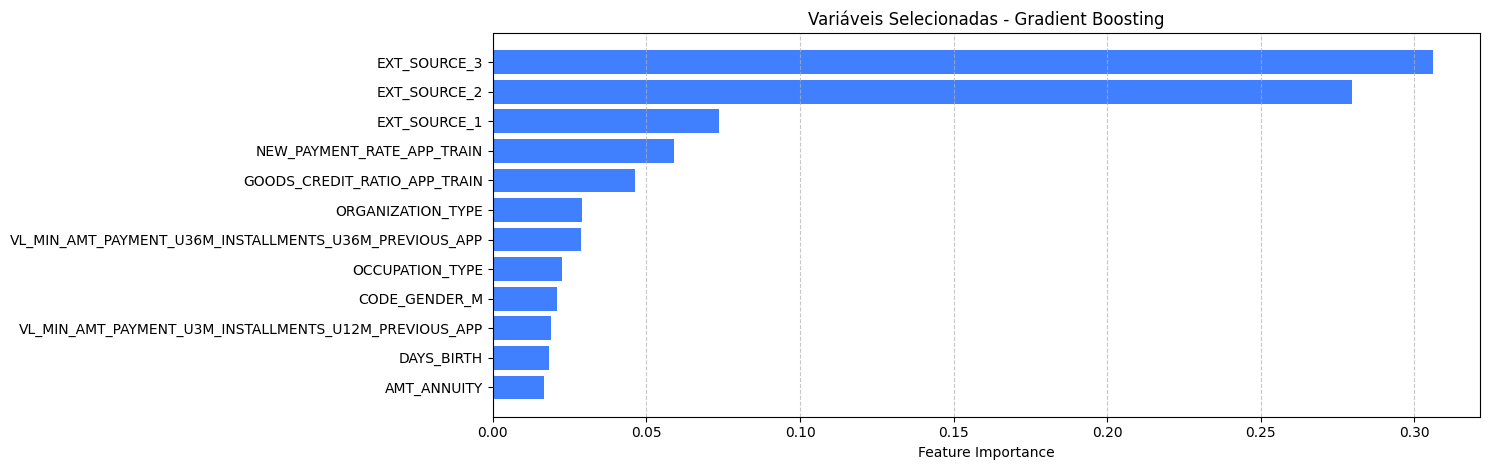

In [ ]:
# Ordenando as variáveis por importância.
features = features.sort_values(by='Importance', ascending=True)

# Filtrando o DataFrame para apenas as features acima do corte.
selected_features_df = features[features['Importance'] > cutoff]

# Visualizando a importância das variáveis em barras horizontais.
plt.figure(figsize=(15, len(selected_features_df)*0.4))
plt.barh(selected_features_df['Feature'], selected_features_df['Importance'], color=(0.25, 0.5, 1))
plt.xlabel('Feature Importance')
plt.title('Variáveis Selecionadas - Gradient Boosting')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Salvando a lista de variáveis selecionadas em um arquivo pkl (artefato).
with open(dir_pkl + '/prd_list_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

In [ ]:
# Carregando a lista do arquivo .pkl.
with open(dir_pkl + '/prd_list_features.pkl', 'rb') as f:
    loaded_lista = pickle.load(f)

print(Fore.BLUE + '=' * 150)
print('')
print('Lista das variáveis selecionadas: ', loaded_lista)
print('')
print('=' * 150 + Style.RESET_ALL)


Lista das variáveis selecionadas:  ['DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'GOODS_CREDIT_RATIO_APP_TRAIN', 'NEW_PAYMENT_RATE_APP_TRAIN', 'AMT_ANNUITY', 'VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP', 'VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'CODE_GENDER_M']



In [ ]:
# Incluindo a variável target na lista de variáveis explicativas selecionadas.
abt_train_04 = abt_train_03[loaded_lista]
abt_train_04 = pd.concat([abt_train_04, target_var_train], axis=1)

abt_test_04 = abt_test_03[loaded_lista]
abt_test_04 = pd.concat([abt_test_04, target_var_test], axis=1)

abt_train_04.shape, abt_test_04.shape

((172205, 13), (43052, 13))

In [ ]:
abt_train_04.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,OCCUPATION_TYPE,ORGANIZATION_TYPE,CODE_GENDER_M,TARGET
0,-0.793053,1.836741e+00,0.061971,-5.029701e-03,1.010821,0.033633,0.475008,-0.368631,-0.164555,0.063887,0.096493,0.0,0
1,-1.156049,-7.967728e-16,0.965016,-8.247463e-01,-2.269965,-0.096974,-0.879459,-0.297123,-0.264697,0.105932,0.092509,1.0,0
2,1.038227,-1.545829e+00,0.877222,-2.071589e+00,1.010821,2.332020,-0.455511,0.000000,0.000000,0.063887,0.092509,0.0,0
3,-1.335136,-7.967728e-16,-1.374206,-1.274619e-15,1.010821,0.138083,-1.339922,0.000000,-0.292035,0.065004,0.053759,0.0,0
4,0.634133,-7.967728e-16,-1.849493,-1.188729e-01,-0.280528,-1.084114,0.732162,0.000000,-0.071142,0.115646,0.092509,0.0,0


In [ ]:
abt_test_04.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,OCCUPATION_TYPE,ORGANIZATION_TYPE,CODE_GENDER_M,TARGET
0,1.482272,-2.046844e+00,0.630504,2.524676e-01,1.010821,-0.164572,-1.248325,-0.163901,0.048876,0.105932,0.092509,1.0,0
1,-0.945047,2.160400e+00,-0.067148,-7.276433e-01,-0.381871,0.031893,1.058633,0.000000,0.000000,0.105932,0.092509,0.0,0
2,1.008839,-7.967728e-16,-1.234555,-1.210403e+00,1.010821,-0.225103,-0.362057,0.000000,-0.064871,0.105932,0.115911,1.0,1
3,1.377575,-1.605800e+00,-1.579867,2.626892e-01,-0.070679,-0.496777,0.356488,0.000000,-0.171151,0.105932,0.092509,0.0,0
4,-0.098057,5.744776e-01,0.074630,-1.274619e-15,-0.672499,-0.946992,-0.064365,0.000000,0.000000,0.063178,0.058163,0.0,0


<br>

### **Mapa de correlação de Pearson para as variáveis selecionadas**

Ao plotar um mapa de correlação de Pearson, podemos visualizar de forma rápida e intuitiva as relações lineares entre as variáveis selecionadas. Uma alta correlação positiva entre duas variáveis sugere que elas variam juntas na mesma direção, enquanto uma alta correlação negativa indica que elas variam inversamente. Por outro lado, uma correlação próxima a zero indica que as variáveis têm pouca ou nenhuma relação linear entre si.
<br>
<br>
Essa análise é importante para identificar se existe alguma alta correlação entre as variáveis, o que pode indicar redundância ou multicolinearidade no conjunto de dados.
  - **Redundância:** Variáveis altamente correlacionadas podem fornecer informações redundantes para o modelo, o que pode levar a uma sobrecarga de informações e aumentar o tempo de treinamento sem melhorar significativamente o desempenho do modelo.
  - **Multicolinearidade:** A multicolinearidade ocorre quando duas ou mais variáveis estão altamente correlacionadas entre si, o que pode levar a problemas na interpretação dos coeficientes do modelo e na instabilidade das previsões.

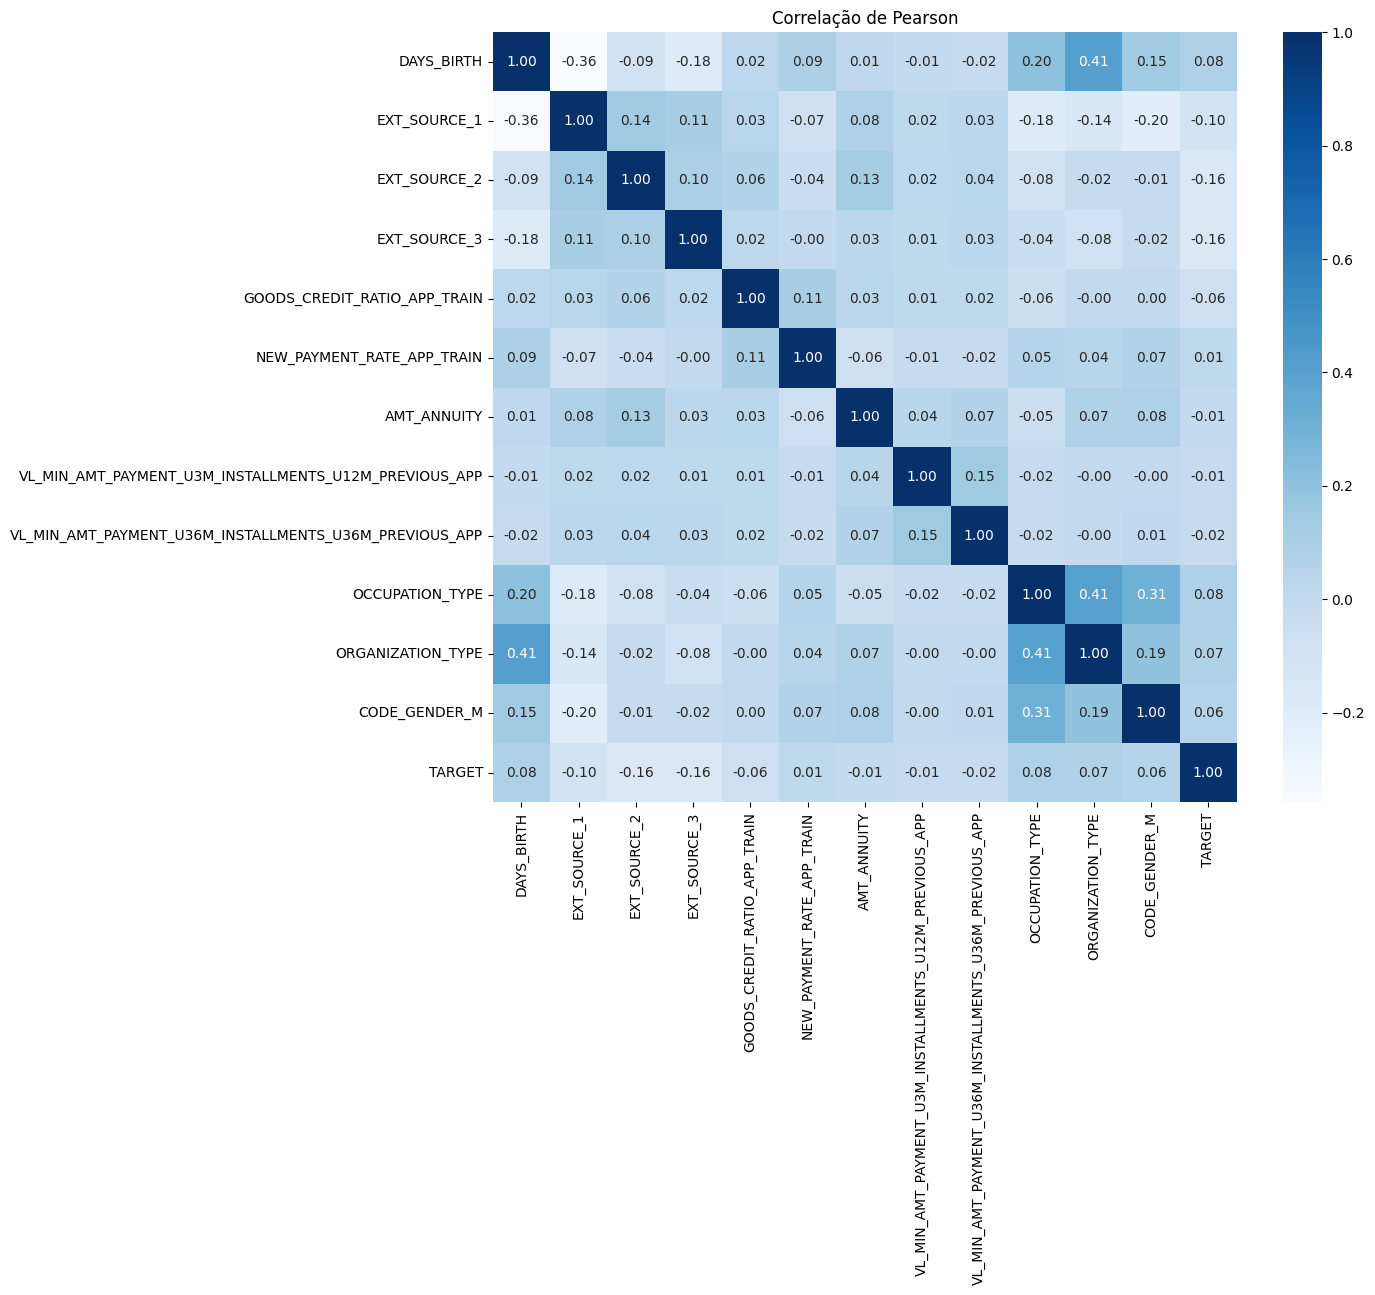

In [ ]:
# Calculando a correlação de Pearson.
abt_train_04_numeric = abt_train_04.select_dtypes(include=['number'])
corr_matrix = abt_train_04_numeric.corr()

# Plotando o heatmap.
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='Blues', annot=True, fmt='.2f')
plt.title('Correlação de Pearson')
plt.show()

Podemos notar que não existem variáveis com alta correlação entre si.

<br>

### **Verificação da força das variáveis explicativas com IV**

O Information Value (IV) é uma medida estatística que avalia a força da relação entre uma variável independente e a variável dependente em um modelo de classificação. O IV é importante porque permite identificar quais variáveis têm maior poder preditivo e contribuição para o modelo, ajudando na priorização e seleção das melhores características para melhorar a precisão do modelo de machine learning. Quanto maior o IV de uma variável, maior é sua capacidade de discriminar entre as classes da variável dependente, o que indica sua importância na previsão do resultado desejado.
<br>
<br>
**Vale ressaltar:** Enquanto a **Feature Importance** é uma medida do quanto cada variável contribui para a capacidade de previsão do modelo, com base na relação de uma variável explicativa com as outras variáveis explicativas o **IV** é uma medida da força da relação entre uma variável explicativa e a variável target em um modelo. Ambas tem sua importância e usabilidade.

In [ ]:
# Fazendo uma amostra dos dados.
abt_corr_aux_sample = abt_train_04.sample(n=15000)

In [ ]:
# Chamando a função.
iv_df = iv_table(abt_corr_aux_sample, 'TARGET')
iv_df

,Variável,IV,Preditividade
2,EXT_SOURCE_2,27.399111,Preditor Forte
0,DAYS_BIRTH,20.856011,Preditor Forte
8,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREV...,20.577216,Preditor Forte
5,NEW_PAYMENT_RATE_APP_TRAIN,16.046986,Preditor Forte
6,AMT_ANNUITY,13.529438,Preditor Forte
1,EXT_SOURCE_1,12.144568,Preditor Forte
7,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVI...,8.546747,Preditor Forte
3,EXT_SOURCE_3,3.344992,Preditor Forte
4,GOODS_CREDIT_RATIO_APP_TRAIN,2.987744,Preditor Forte
10,ORGANIZATION_TYPE,0.220329,Preditor Moderado


<br>

### **Remoção das variáveis de acordo com a análise da Matriz de Correlação e do Information Value (IV)**

**Remoção das variáveis com alta correlação**

O código abaixo pega os pares de variáveis com correlação maior ou igual ao limiar determinado. Em cada par, ele vai verificar a variável que tem o menor IV e vai coloca-la em uma lista para ser removida.

In [ ]:
# Definindo limiar de correlação.
limiar_corr = 0.70

# Criando uma lista com pares de variáveis com correlação absoluta >= o limiar.
corr_pairs = [(corr_matrix.columns[i], corr_matrix.columns[j])
              for i in range(len(corr_matrix.columns))
              for j in range(i + 1, len(corr_matrix.columns))
              if abs(corr_matrix.iloc[i, j]) >= limiar_corr]

# Encontrando as variáveis com menor IV em cada par e adicionando à lista vars_to_drop_corr.
vars_to_drop_corr = []
for var1, var2 in corr_pairs:
    iv_values = iv_df.set_index('Variável').loc[[var1, var2], 'IV']
    var_to_drop = iv_values.idxmin()
    vars_to_drop_corr.append(var_to_drop)

# Removendo duplicatas da lista vars_to_drop_corr.
vars_to_drop_corr = list(set(vars_to_drop_corr))

# Imprimindo o resultado.
print(Fore.BLUE + '=' * 150)
print('')
print('Lista de variáveis para remover devido à alta correlação e baixo IV:', vars_to_drop_corr)
print('')
print('=' * 150 + Style.RESET_ALL)


Lista de variáveis para remover devido à alta correlação e baixo IV: []



In [ ]:
# Removendo as variáveis com alta correlação.
abt_train_05 = abt_train_04.drop(abt_train_04[vars_to_drop_corr], axis=1)

abt_train_05.shape

(172205, 13)

In [ ]:
abt_train_05.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,OCCUPATION_TYPE,ORGANIZATION_TYPE,CODE_GENDER_M,TARGET
0,-0.793053,1.836741e+00,0.061971,-5.029701e-03,1.010821,0.033633,0.475008,-0.368631,-0.164555,0.063887,0.096493,0.0,0
1,-1.156049,-7.967728e-16,0.965016,-8.247463e-01,-2.269965,-0.096974,-0.879459,-0.297123,-0.264697,0.105932,0.092509,1.0,0
2,1.038227,-1.545829e+00,0.877222,-2.071589e+00,1.010821,2.332020,-0.455511,0.000000,0.000000,0.063887,0.092509,0.0,0
3,-1.335136,-7.967728e-16,-1.374206,-1.274619e-15,1.010821,0.138083,-1.339922,0.000000,-0.292035,0.065004,0.053759,0.0,0
4,0.634133,-7.967728e-16,-1.849493,-1.188729e-01,-0.280528,-1.084114,0.732162,0.000000,-0.071142,0.115646,0.092509,0.0,0


In [ ]:
# Salvando a lista de variáveis removidas em um arquivo pkl (artefato).
with open(dir_pkl + '/prd_vars_to_drop_corr.pkl', 'wb') as f:
    pickle.dump(vars_to_drop_corr, f)

In [ ]:
# Carregando o pkl com a lista de variáveis a serem removidas.
with open(dir_pkl + '/prd_vars_to_drop_corr.pkl', 'rb') as f:
    loaded_vars_to_drop_corr = pickle.load(f)

# Aplicando a remoção das variáveis na tabela de teste.
abt_test_05 = abt_test_04.drop(axis=1, columns=loaded_vars_to_drop_corr)

abt_test_05.shape

(43052, 13)

In [ ]:
abt_test_05.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,OCCUPATION_TYPE,ORGANIZATION_TYPE,CODE_GENDER_M,TARGET
0,1.482272,-2.046844e+00,0.630504,2.524676e-01,1.010821,-0.164572,-1.248325,-0.163901,0.048876,0.105932,0.092509,1.0,0
1,-0.945047,2.160400e+00,-0.067148,-7.276433e-01,-0.381871,0.031893,1.058633,0.000000,0.000000,0.105932,0.092509,0.0,0
2,1.008839,-7.967728e-16,-1.234555,-1.210403e+00,1.010821,-0.225103,-0.362057,0.000000,-0.064871,0.105932,0.115911,1.0,1
3,1.377575,-1.605800e+00,-1.579867,2.626892e-01,-0.070679,-0.496777,0.356488,0.000000,-0.171151,0.105932,0.092509,0.0,0
4,-0.098057,5.744776e-01,0.074630,-1.274619e-15,-0.672499,-0.946992,-0.064365,0.000000,0.000000,0.063178,0.058163,0.0,0


<br>

**Remoção das variáveis de acordo com o valor do IV**

In [ ]:
# Criando uma lista vazia para armazenar os nomes das colunas com preditividade "Inútil para a predição".
vars_to_drop_iv = []

# Criando uma lista com os critérios que queremos filtrar.
status_predit = ['Inútil para a predição']  # Podemos também filtrar por 'Preditor Fraco'.

# Itera sobre as linhas do DataFrame iv_df.
for index, row in iv_df.iterrows():
    # Verifica se a preditividade está dentro dos critérios que queremos filtrar.
    if row['Preditividade'] in status_predit:
        # Adicionar o nome da coluna à lista vars_to_drop_iv.
        vars_to_drop_iv.append(row['Variável'])

# Iterando sobre as listas criadas.
for item in vars_to_drop_corr:
    if item in vars_to_drop_iv:
        vars_to_drop_iv.remove(item)

# Imprimindo o resultado.
print(Fore.BLUE + '=' * 150)
print('')
print('Lista de variáveis para remover devido ao baixo valor de IV:', vars_to_drop_iv)
print('')
print('=' * 150 + Style.RESET_ALL)


Lista de variáveis para remover devido ao baixo valor de IV: []



In [ ]:
# Removendo as variáveis com alta correlação.
abt_train_06 = abt_train_05.drop(abt_train_05[vars_to_drop_iv], axis=1)

abt_train_06.shape

(172205, 13)

In [ ]:
abt_train_06.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,OCCUPATION_TYPE,ORGANIZATION_TYPE,CODE_GENDER_M,TARGET
0,-0.793053,1.836741e+00,0.061971,-5.029701e-03,1.010821,0.033633,0.475008,-0.368631,-0.164555,0.063887,0.096493,0.0,0
1,-1.156049,-7.967728e-16,0.965016,-8.247463e-01,-2.269965,-0.096974,-0.879459,-0.297123,-0.264697,0.105932,0.092509,1.0,0
2,1.038227,-1.545829e+00,0.877222,-2.071589e+00,1.010821,2.332020,-0.455511,0.000000,0.000000,0.063887,0.092509,0.0,0
3,-1.335136,-7.967728e-16,-1.374206,-1.274619e-15,1.010821,0.138083,-1.339922,0.000000,-0.292035,0.065004,0.053759,0.0,0
4,0.634133,-7.967728e-16,-1.849493,-1.188729e-01,-0.280528,-1.084114,0.732162,0.000000,-0.071142,0.115646,0.092509,0.0,0


In [ ]:
# Salvando a lista de variáveis removidas em um arquivo pkl (artefato).
with open(dir_pkl + '/prd_vars_to_drop_iv.pkl', 'wb') as f:
    pickle.dump(vars_to_drop_iv, f)

In [ ]:
# Carregando o pkl com a lista de variáveis a serem removidas.
with open(dir_pkl + '/prd_vars_to_drop_iv.pkl', 'rb') as f:
    loaded_vars_to_drop_iv = pickle.load(f)

# Aplicando a remoção das variáveis na tabela de teste.
abt_test_06 = abt_test_05.drop(axis=1, columns=loaded_vars_to_drop_iv)

abt_test_06.shape

(43052, 13)

In [ ]:
abt_test_06.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,OCCUPATION_TYPE,ORGANIZATION_TYPE,CODE_GENDER_M,TARGET
0,1.482272,-2.046844e+00,0.630504,2.524676e-01,1.010821,-0.164572,-1.248325,-0.163901,0.048876,0.105932,0.092509,1.0,0
1,-0.945047,2.160400e+00,-0.067148,-7.276433e-01,-0.381871,0.031893,1.058633,0.000000,0.000000,0.105932,0.092509,0.0,0
2,1.008839,-7.967728e-16,-1.234555,-1.210403e+00,1.010821,-0.225103,-0.362057,0.000000,-0.064871,0.105932,0.115911,1.0,1
3,1.377575,-1.605800e+00,-1.579867,2.626892e-01,-0.070679,-0.496777,0.356488,0.000000,-0.171151,0.105932,0.092509,0.0,0
4,-0.098057,5.744776e-01,0.074630,-1.274619e-15,-0.672499,-0.946992,-0.064365,0.000000,0.000000,0.063178,0.058163,0.0,0


<br>

### **Dropando colunas com dados sensíveis e trazendo o ID novamente para a tabela**

In [ ]:
# Lista de colunas que iremos dropar.
col_to_drop = ['CODE_GENDER_M']

# Dropando as colunas do DataFrame.
abt_train_07 = abt_train_06.drop(columns=col_to_drop)
abt_test_07 = abt_test_06.drop(columns=col_to_drop)

# Trazaneo o ID novamente.
abt_train_08 = pd.concat([abt_train_07, id_var_train], axis=1)
abt_test_08 = pd.concat([abt_test_07, id_var_test], axis=1)

info_dataframe(abt_train_08, abt_test_08)

              CONJUNTO DE TREINO             

Quantidade de linhas: 172205
Quantidade de colunas: 13

              CONJUNTO DE TESTE              

Quantidade de linhas: 43052
Quantidade de colunas: 13


<br>
<br>
<br>
<br>

## **Salvando as ABTs tratadas e prontas para modelagem**

In [ ]:
# Salvando o conjunto de treino.
abt_train_08.to_csv(dir_abt + '/abt_train_01.csv', index=False)

In [ ]:
# Salvando o conjunto de teste.
abt_test_08.to_csv(dir_abt + '/abt_test_01.csv', index=False)